# 训练过程

In [404]:
import scipy.io
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from d2l import torch as d2l
import numpy as np
import argparse
import datetime
import wandb 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 后面还要做混淆矩阵

# 参数解析器
parser = argparse.ArgumentParser()
parser.add_argument('--project_name', type=str, default='DSC_CNN_demo01', help='project_name')
parser.add_argument('--batch_size', type=int, default=32, help='size of each image batch')
parser.add_argument('--lr', type=float, default=0.001, help='learning rate')
parser.add_argument('--optim_type', type=str, default='Adam', help='Optimizer')
parser.add_argument('--epochs', type=int, default=100, help='epochs')
parser.add_argument('--model_pth_name', type=str, default='../save/model_default.pth', help='pth_name')
# 不会解析命令行参数
args = parser.parse_args([])
# 返回一个NameSpace对象

def min_max_normalize(data, dim=-1):
    """
    对输入数据在指定维度上进行 Min - Max 归一化
    """
    min_vals = data
    min_vals, _ = torch.min(min_vals, dim=dim, keepdim=True)
    max_vals = data
    max_vals, _ = torch.max(max_vals, dim=dim, keepdim=True)
    
    denominator = max_vals - min_vals
    denominator[denominator == 0] = 1e-8
    
    normalized_data = (data - min_vals) / denominator
    return normalized_data

def zero_out_large_numbers(data):
    """
    将数据中大于 1500 的数置为 0
    """
    data[data > 1500] = 0
    return data

def create_input_iamge(data, length):
    num = data.size//(length**2)
    data = data[:num*(length**2)].reshape((num, 1, length, length))
    data = torch.tensor(data, dtype=torch.float32)
    # Max-Min 归一化
    data = min_max_normalize(data, dim=-1)
    # 滤去异常值
    data = zero_out_large_numbers(data)
    return data

def create_dataloaders(length, Data_names, Data_names_key, Labels, data_path, is_train=1, batch_size = args.batch_size):
    for i in range(len(Data_names)):
        print('正在读取：' + Data_names[i])
        mat_data = scipy.io.loadmat(data_path + Data_names[i])
        numpy_X =  np.squeeze(mat_data[Data_names_key[i]])
        print('ndarry 形状：', numpy_X.shape)
        tensor_X = create_input_iamge(numpy_X, length)
        tensor_y = torch.full((tensor_X.shape[0],), Labels[i], dtype=torch.int64)
        print('tensor 形状：', tensor_X.shape)
        if i==0:
            X = tensor_X
            y = tensor_y
        else:
            # dim是轴而不是方向i
            X = torch.cat([X, tensor_X], dim=0)
            y = torch.cat([y, tensor_y], dim=0)
    print('模型输入的 tensor 形状为：', X.shape)
    print('对应标签的 tensor 形状为：', y.shape)
    
    dataset = TensorDataset(X, y)
    if is_train:
        train_size = int(0.7 * len(dataset))
        val_size = len(dataset) - train_size
        # 随机73划分数据集
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
        # Dataloader类型具有__iter__()方法，在迭代时会返回一个迭代器
        train_dataloader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=2,
            drop_last=True
        )
        val_dataloader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=2,
            drop_last=True
        )
        return train_dataloader, val_dataloader
    
    else:
        infer_dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=2,
            drop_last=True
        )
        return infer_dataloader

In [384]:
# 定义深度可分离卷积层
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, padding=padding, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

# 定义Fire模块
class FireModule(nn.Module):
    def __init__(self, in_channels, squeeze_channels, expand_channels):
        super(FireModule, self).__init__()
        self.squeeze = nn.Conv2d(in_channels, squeeze_channels, kernel_size=1)
        self.expand1x1 = nn.Conv2d(squeeze_channels, expand_channels, kernel_size=1)
        self.expand3x3 = nn.Conv2d(squeeze_channels, expand_channels, kernel_size=3, padding=1)
    
    def forward(self, x):
        x = self.squeeze(x)
        x = torch.relu(x)
        return torch.cat([
            torch.relu(self.expand1x1(x)),
            torch.relu(self.expand3x3(x))
        ], 1)

# 定义卷积神经网络
class DSC_CNN(nn.Module):
    def __init__(self):
        super(DSC_CNN, self).__init__()
        self.layer1 = DepthwiseSeparableConv(1, 32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fire = FireModule(32, 16, 32)
        self.concat_conv = DepthwiseSeparableConv(64, 64) # 64 because FireModule output is concatenated
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.5) # 推理时默认不会调用
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 4)
        # self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.layer1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        x = self.fire(x)
        x = self.concat_conv(x)
        x = torch.relu(x)
        x = self.pool2(x)
        x = self.dropout(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        # 改动1：避免softmax重复计算
        # x = self.softmax(x) 
        return x

In [438]:
def train_epoch(model, dataloader, optimizer):
    model.train()
    for step, batch in enumerate(dataloader):
        features, labels = batch
        features, labels = features.to(device),labels.to(device)

        preds = model(features)
        loss = nn.CrossEntropyLoss()(preds,labels)        
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
    return loss, model

def eval_epoch(model, dataloader):
    model.eval()
    accurate = 0
    num_elems = 0
    loss = 0
    num_batches = 0
    for batch in dataloader:
        features,labels = batch
        features,labels = features.to(device),labels.to(device)
        with torch.no_grad():
            preds = model(features)
        loss_batch = nn.CrossEntropyLoss()(preds, labels)
        loss += loss_batch
        num_batches += 1
        predictions = preds.argmax(dim=-1)
        accurate_preds = (predictions==labels)
        num_elems += accurate_preds.shape[0]
        accurate += accurate_preds.long().sum()# bool值转化为long
        
    val_acc = accurate.item() / num_elems
    loss = loss / num_batches
    return val_acc, loss

def train(args = args):
    Data_names = ['old_200_0', '100_1', '100_2_0', '100_2_90', '100_2_180', '100_3']
    Data_names_key = ['dataset', 'dataset', 'dataset', 'dataset', 'dataset', 'dataset']
    Labels = [0, 1, 2, 2, 2, 3]
    train_dataloader, val_dataloader = create_dataloaders(32, Data_names, Data_names_key, Labels, '../data/dataset03/')
    
    model = DSC_CNN()
    model.to(device)
    optimizer = torch.optim.__dict__[args.optim_type](params=model.parameters(), lr=args.lr)
    #======================================================================
    # nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    # wandb.init(project=args.project_name, config = args.__dict__, name = nowtime, save_code=True)
    # model.run_id = wandb.run.id
    #======================================================================    
    # model.best_metric = -1.0
    train_loss_list = []
    val_loss_list = []
    val_acc_list = []
    for epoch in range(1,args.epochs+1):
        train_loss, model = train_epoch(model, train_dataloader, optimizer)
        val_acc, val_loss = eval_epoch(model, val_dataloader)
        train_loss_list.append(train_loss.item())
        val_loss_list.append(val_loss.item())
        val_acc_list.append(val_acc)
        # if val_acc > model.best_metric:
        #     model.best_metric = val_acc
        #     torch.save(model.state_dict(),config.ckpt_path)   
        nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        if epoch % 10 == 0:
            print(f"epoch【{epoch}】@{nowtime} --> val_acc= {100 * val_acc:.2f}%")
        
        #======================================================================
        # wandb.log({'train_loss':train_loss, 'val_loss':val_loss, 'val_acc': val_acc})
        #======================================================================        
    # print(train_loss_list, val_loss_list, val_acc_list)
    d2l.plot(list(range(1, args.epochs + 1)), [train_loss_list, val_loss_list, val_acc_list],
         xlabel='epoch', ylabel='loss', xlim=[1, args.epochs], ylim=[0, 1.5],
         legend=['train_loss', 'valid_loss', 'valid_acc'], yscale='linear')
    
    torch.save(model.state_dict(), args.model_pth_name)
    # wandb.finish()
    return model

正在读取：old_200_0
ndarry 形状： (204800,)
tensor 形状： torch.Size([200, 1, 32, 32])
正在读取：100_1
ndarry 形状： (102400,)
tensor 形状： torch.Size([100, 1, 32, 32])
正在读取：100_2_0
ndarry 形状： (102400,)
tensor 形状： torch.Size([100, 1, 32, 32])
正在读取：100_2_90
ndarry 形状： (102400,)
tensor 形状： torch.Size([100, 1, 32, 32])
正在读取：100_2_180
ndarry 形状： (102400,)
tensor 形状： torch.Size([100, 1, 32, 32])
正在读取：100_3
ndarry 形状： (102400,)
tensor 形状： torch.Size([100, 1, 32, 32])
模型输入的 tensor 形状为： torch.Size([700, 1, 32, 32])
对应标签的 tensor 形状为： torch.Size([700])
epoch【10】@2025-04-24 22:33:24 --> val_acc= 41.67%
epoch【20】@2025-04-24 22:33:28 --> val_acc= 47.40%
epoch【30】@2025-04-24 22:33:32 --> val_acc= 51.56%
epoch【40】@2025-04-24 22:33:35 --> val_acc= 59.90%
epoch【50】@2025-04-24 22:33:39 --> val_acc= 71.35%
epoch【60】@2025-04-24 22:33:43 --> val_acc= 69.79%
epoch【70】@2025-04-24 22:33:46 --> val_acc= 75.52%
epoch【80】@2025-04-24 22:33:50 --> val_acc= 77.08%
epoch【90】@2025-04-24 22:33:53 --> val_acc= 77.60%
epoch【100】@2025-04-24 

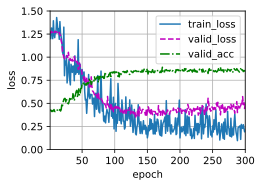

In [439]:
args.model_pth_name = '../save/model_new.pth'
args.epochs = 300
args.batch_size = 32
model = train(args)

## 下面为推理

In [446]:
Data_names = ['old_100_0', '50_1', '50_2_0', '50_2_90', '50_2_180', '50_3']
Data_names_key = [ 'dataset', 'dataset', 'dataset', 'dataset', 'dataset', 'dataset']
Labels = [0, 1, 2, 2, 2, 3]

# Data_names = ['100_0', '50_1', '50_2_0', '50_2_180', '50_3']
# Data_names_key = [ 'dataset', 'dataset', 'dataset', 'dataset', 'dataset']
# Labels = [0, 1, 2, 2, 3]

# Data_names = ['100_0', '50_1', '50_2_0', '50_2_180']
# Data_names_key = [ 'dataset', 'dataset', 'dataset', 'dataset']
# Labels = [0, 1, 2, 2]

Data_names = ['old_100_0']
Data_names_key = [ 'dataset']
Labels = [0]

Data_names = ['50_1']
Data_names_key = [ 'dataset']
Labels = [1]

Data_names = ['50_3']
Data_names_key = [ 'dataset']
Labels = [3]

Data_names = ['50_2_0']
Data_names_key = [ 'dataset']
Labels = [2]

Data_names = ['50_2_90']
Data_names_key = [ 'dataset']
Labels = [2]

Data_names = ['50_2_180']
Data_names_key = [ 'dataset']
Labels = [2]

# Data_names = ['try']
# Data_names_key = [ 'dataset']
# Labels = [0]

args.batch_size = 32
pre_dataloaders = create_dataloaders(32, Data_names, Data_names_key, Labels, '../data/pre03/', is_train=0, batch_size=args.batch_size)
pre_dataloaders_iter = iter(pre_dataloaders)
# 查看一batch_size的数据
# next(pre_dataloaders.__iter__())[0].shape, next(pre_dataloaders.__iter__())[1].shape
acc,_ = eval_epoch(model, pre_dataloaders)
acc

正在读取：50_2_180
ndarry 形状： (51200,)
tensor 形状： torch.Size([50, 1, 32, 32])
模型输入的 tensor 形状为： torch.Size([50, 1, 32, 32])
对应标签的 tensor 形状为： torch.Size([50])


0.875

# 下面为调试代码，正式版需删除

In [ ]:
next(pre_dataloaders_iter)[0]

In [356]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_waveform(tensor, sample_idx=0):
    """
    绘制张量最后两个维度的连续波形图，包含正负区域区分，且会删去大于100的数

    参数:
        tensor (torch.Tensor/np.ndarray): 输入张量，至少包含两个维度
        sample_idx (int): 当张量有批次维度时选择的具体样本索引
    """
    # 转换为NumPy数组（如果输入是PyTorch张量）
    if isinstance(tensor, torch.Tensor):
        data = tensor.detach().cpu().numpy()
    else:
        data = np.asarray(tensor)

    # 检查数据维度
    if data.ndim < 2:
        raise ValueError("输入张量至少需要两个维度")

    # 检查 sample_idx 是否合法
    if data.ndim > 2 and (sample_idx < 0 or sample_idx >= data.shape[0]):
        raise IndexError(f"sample_idx {sample_idx} 超出范围，输入张量批次维度大小为 {data.shape[0]}")

    # 获取最后两个维度并展平为一维
    last_two_dims = data.shape[-2:]
    flattened = data.reshape(-1, last_two_dims[0] * last_two_dims[1])

    # 选择具体样本（如张量有批次维度）
    if flattened.shape[0] > 1:
        waveform = flattened[sample_idx]
    else:
        waveform = flattened[0]

    # 删去大于100的数
    # waveform = waveform[waveform <= 500]

    # 绘制波形
    plt.figure(figsize=(12, 4))
    plt.plot(waveform, linewidth=1)

    # 添加区分正负区域的水平线
    plt.axhline(y=0, color='r', linestyle='--', label='Zero Line')

    plt.title(f"Waveform (Length: {len(waveform)})")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

In [374]:
next(pre_dataloaders_iter)[0][0,0,31,:]

tensor([ 3.0675e-01,  3.0675e-01,  3.0675e-01, -3.0675e-01,  0.0000e+00,
         0.0000e+00,  3.0675e-01, -3.0675e-01,  0.0000e+00,  3.0675e-01,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  3.0675e-01,  0.0000e+00,
         3.0675e-01,  6.1350e-01,  2.1018e+03,  3.0675e-01,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  6.1350e-01, -6.1350e-01,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         3.0675e-01,  6.1350e-01])

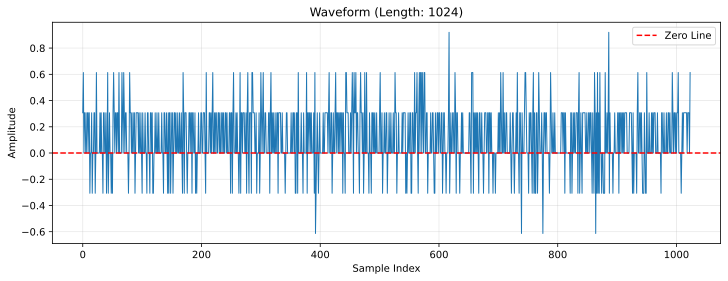

In [403]:
# 每次运行迭代一张新的波形图，记得批次设置1，注释掉归一化

plot_waveform(next(pre_dataloaders_iter)[0], sample_idx=0)

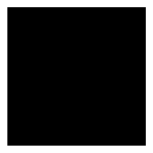

In [303]:
# 每次运行迭代一张新的特征图，记得批次设置1
# next(pre_dataloaders_iter)[0][0,0,:,:].shape
plt.imshow(next(pre_dataloaders_iter)[0][0,0,:,:], cmap='gray')
plt.axis('off')
plt.show()